# Clustering

In [1]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
np.set_printoptions(precision=3, suppress=True)
import pandas as pd
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler

# KMeans

In [2]:
from sklearn.datasets import make_blobs
from sklearn.cluster import KMeans

(5, 2)
(100,)
(100,)


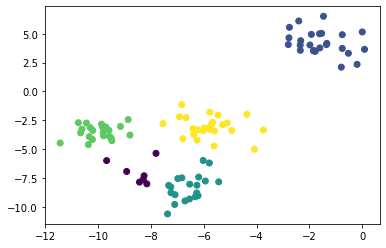

In [3]:
X, y = make_blobs(centers=4, random_state=1)

km = KMeans(n_clusters=5, random_state=0)
km.fit(X)
print(km.cluster_centers_.shape)
print(km.labels_.shape)
# predict is the same as labels_ on training data
# but can be applied to new data
print(km.predict(X).shape)
plt.scatter(X[:, 0], X[:, 1],  c=km.labels_)

In [4]:
km.cluster_centers_

array([[-8.511, -6.994],
       [-1.561,  4.219],
       [-6.574, -8.316],
       [-9.963, -3.485],
       [-5.803, -3.066]])

In [5]:
print("Cluster memberships:\n{}".format(km.labels_))

Cluster memberships:
[0 3 2 3 1 1 4 4 4 2 4 4 3 4 2 4 4 2 1 1 2 0 2 3 1 4 4 2 3 1 1 2 1 3 2 1 2
 4 3 2 0 4 4 3 2 1 2 3 2 1 3 1 1 3 4 2 1 1 0 3 4 1 3 3 4 2 4 3 4 1 3 0 2 4
 3 1 3 2 4 1 3 0 2 0 4 1 1 1 1 3 1 4 1 3 3 2 4 4 3 4]


In [6]:
print(km.predict(X))

[0 3 2 3 1 1 4 4 4 2 4 4 3 4 2 4 4 2 1 1 2 0 2 3 1 4 4 2 3 1 1 2 1 3 2 1 2
 4 3 2 0 4 4 3 2 1 2 3 2 1 3 1 1 3 4 2 1 1 0 3 4 1 3 3 4 2 4 3 4 1 3 0 2 4
 3 1 3 2 4 1 3 0 2 0 4 1 1 1 1 3 1 4 1 3 3 2 4 4 3 4]


In [7]:
X_new = np.array([[0, 2], [-10, -2], [-3, 3], [-8, 2.5]])
km.predict(X_new)

array([1, 3, 1, 4])

Rather than arbitrarily choosing the closest cluster for each instance, which is called _hard clustering_, it might be better measure the distance of each instance to all centroids. This is what the `transform()` method does:

In [8]:
km.transform(X_new)

array([[12.382,  2.713, 12.233, 11.373,  7.703],
       [ 5.211, 10.483,  7.185,  1.485,  4.33 ],
       [11.412,  1.886, 11.867,  9.515,  6.682],
       [ 9.508,  6.664, 10.91 ,  6.298,  5.984]])

You can verify that this is indeed the Euclidian distance between each instance and each centroid:

In [9]:
k = 5
np.linalg.norm(np.tile(X_new, (1, k)).reshape(-1, k, 2) - km.cluster_centers_, axis=2)

array([[12.382,  2.713, 12.233, 11.373,  7.703],
       [ 5.211, 10.483,  7.185,  1.485,  4.33 ],
       [11.412,  1.886, 11.867,  9.515,  6.682],
       [ 9.508,  6.664, 10.91 ,  6.298,  5.984]])

### Using Clustering for Preprocessing

Let's tackle the _digits dataset_ which is a simple MNIST-like dataset containing 1,797 grayscale 8×8 images representing digits 0 to 9.

In [10]:
from sklearn.datasets import load_digits

In [11]:
X_digits, y_digits = load_digits(return_X_y=True)

Let's split it into a training set and a test set:

In [12]:
from sklearn.model_selection import train_test_split

In [13]:
X_train, X_test, y_train, y_test = train_test_split(X_digits, y_digits, random_state=42)

Now let's fit a Logistic Regression model and evaluate it on the test set:

In [14]:
from sklearn.linear_model import LogisticRegression

In [15]:
log_reg = LogisticRegression(multi_class="ovr", solver="lbfgs", max_iter=5000, random_state=42)
log_reg.fit(X_train, y_train)

LogisticRegression(max_iter=5000, multi_class='ovr', random_state=42)

In [16]:
log_reg_score = log_reg.score(X_test, y_test)
log_reg_score

0.9688888888888889

Okay, that's our baseline: 96.89% accuracy. Let's see if we can do better by using K-Means as a preprocessing step. We will create a pipeline that will first cluster the training set into 50 clusters and replace the images with their distances to the 50 clusters, then apply a logistic regression model:

In [17]:
from sklearn.pipeline import Pipeline

In [18]:
pipeline = Pipeline([
    ("kmeans", KMeans(n_clusters=50, random_state=42)),
    ("log_reg", LogisticRegression(multi_class="ovr", solver="lbfgs", max_iter=5000, random_state=42)),
])
pipeline.fit(X_train, y_train)

Pipeline(steps=[('kmeans', KMeans(n_clusters=50, random_state=42)),
                ('log_reg',
                 LogisticRegression(max_iter=5000, multi_class='ovr',
                                    random_state=42))])

In [19]:
pipeline_score = pipeline.score(X_test, y_test)
pipeline_score

0.9777777777777777

How much did the error rate drop?

In [20]:
1 - (1 - pipeline_score) / (1 - log_reg_score)

0.28571428571428414

How about that? We reduced the error rate by over 20%! But we chose the number of clusters $k$ completely arbitrarily, we can surely do better. Since K-Means is just a preprocessing step in a classification pipeline, finding a good value for $k$ is much simpler than earlier: there's no need to perform silhouette analysis or minimize the inertia, the best value of $k$ is simply the one that results in the best classification performance.

In [21]:
from sklearn.model_selection import GridSearchCV

**Warning**: the following cell may take close to 5 minutes to run, or more depending on your hardware.

In [22]:
param_grid = dict(kmeans__n_clusters=range(2, 100, 2))
grid_clf = GridSearchCV(pipeline, param_grid, cv=3, verbose=2)
grid_clf.fit(X_train, y_train)

Fitting 3 folds for each of 49 candidates, totalling 147 fits
[CV] END ...............................kmeans__n_clusters=2; total time=   0.1s
[CV] END ...............................kmeans__n_clusters=2; total time=   0.1s
[CV] END ...............................kmeans__n_clusters=2; total time=   0.1s
[CV] END ...............................kmeans__n_clusters=4; total time=   0.2s
[CV] END ...............................kmeans__n_clusters=4; total time=   0.2s
[CV] END ...............................kmeans__n_clusters=4; total time=   0.1s
[CV] END ...............................kmeans__n_clusters=6; total time=   0.2s
[CV] END ...............................kmeans__n_clusters=6; total time=   0.3s
[CV] END ...............................kmeans__n_clusters=6; total time=   0.2s
[CV] END ...............................kmeans__n_clusters=8; total time=   0.4s
[CV] END ...............................kmeans__n_clusters=8; total time=   0.4s
[CV] END ...............................kmeans_

[CV] END ..............................kmeans__n_clusters=68; total time=   3.5s
[CV] END ..............................kmeans__n_clusters=70; total time=   3.4s
[CV] END ..............................kmeans__n_clusters=70; total time=   4.6s
[CV] END ..............................kmeans__n_clusters=70; total time=   4.5s
[CV] END ..............................kmeans__n_clusters=72; total time=   3.9s
[CV] END ..............................kmeans__n_clusters=72; total time=   4.0s
[CV] END ..............................kmeans__n_clusters=72; total time=   3.8s
[CV] END ..............................kmeans__n_clusters=74; total time=   3.6s
[CV] END ..............................kmeans__n_clusters=74; total time=   4.1s
[CV] END ..............................kmeans__n_clusters=74; total time=   3.8s
[CV] END ..............................kmeans__n_clusters=76; total time=   3.7s
[CV] END ..............................kmeans__n_clusters=76; total time=   3.6s
[CV] END ...................

C:\Users\LSBAdmin\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:763: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


GridSearchCV(cv=3,
             estimator=Pipeline(steps=[('kmeans',
                                        KMeans(n_clusters=50, random_state=42)),
                                       ('log_reg',
                                        LogisticRegression(max_iter=5000,
                                                           multi_class='ovr',
                                                           random_state=42))]),
             param_grid={'kmeans__n_clusters': range(2, 100, 2)}, verbose=2)

Let's see what the best number of clusters is:

In [23]:
grid_clf.best_params_

{'kmeans__n_clusters': 88}

In [24]:
grid_clf.score(X_test, y_test)

0.9822222222222222

# Agglomerative Clustering

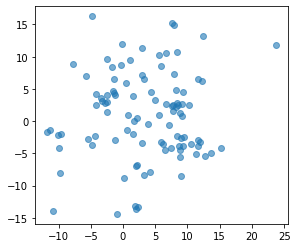

In [25]:
rng = np.random.RandomState(325)
X, y = make_blobs(n_samples=100, centers=10, random_state=rng, cluster_std=[rng.gamma(2) for i in range(10)])
plt.scatter(X[:, 0], X[:, 1], alpha=.6)
plt.gca().set_aspect("equal")
xlim = plt.xlim()
ylim = plt.ylim()

single : [96  1  1  1  1]
average : [82  9  7  1  1]
complete : [50 24 14 11  1]
ward : [31 30 20 10  9]


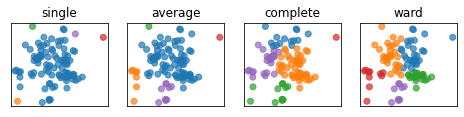

In [26]:
from sklearn.cluster import AgglomerativeClustering
fig, axes = plt.subplots(1, 4, figsize=(8, 3), subplot_kw={"xticks":(), "yticks": ()})
for ax, linkage in zip(axes, ['single', "average", "complete", 'ward']):
    agg = AgglomerativeClustering(n_clusters=5, linkage=linkage)
    agg.fit(X)
    ax.scatter(X[:, 0], X[:, 1], c=plt.cm.tab10(agg.labels_), alpha=.7)
    ax.set_title(linkage)
    ax.set_aspect("equal")
    print("{} : {}".format(linkage, np.sort(np.bincount(agg.labels_))[::-1]))

Text(0, 0.5, 'Cluster distance')

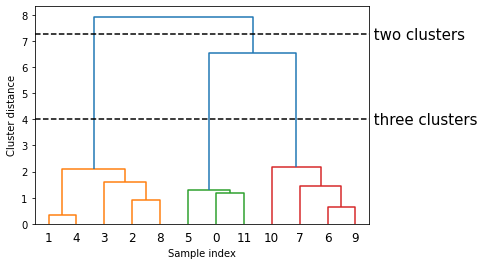

In [27]:
# Import the dendrogram function and the ward clustering function from SciPy
from scipy.cluster.hierarchy import dendrogram, ward

X, y = make_blobs(random_state=0, n_samples=12)
# Apply the ward clustering to the data array X
# The SciPy ward function returns an array that specifies the distances
# bridged when performing agglomerative clustering
linkage_array = ward(X)
# Now we plot the dendrogram for the linkage_array containing the distances
# between clusters
dendrogram(linkage_array)

# mark the cuts in the tree that signify two or three clusters
ax = plt.gca()
bounds = ax.get_xbound()
ax.plot(bounds, [7.25, 7.25], '--', c='k')
ax.plot(bounds, [4, 4], '--', c='k')

ax.text(bounds[1], 7.25, ' two clusters', va='center', fontdict={'size': 15})
ax.text(bounds[1], 4, ' three clusters', va='center', fontdict={'size': 15})
plt.xlabel("Sample index")
plt.ylabel("Cluster distance")

# DBSCAN

In [28]:
#Evaluating clustering without ground truth
from sklearn.metrics.cluster import silhouette_score 

#Evaluating clustering with ground truth
from sklearn.metrics.cluster import adjusted_rand_score 

In [29]:
from sklearn.datasets import make_moons
X, y = make_moons(n_samples=200, noise=0.05, random_state=0)

# Rescale the data to zero mean and unit variance
scaler = StandardScaler()
scaler.fit(X)
X_scaled = scaler.transform(X)

0.49304627727701233
0.5015957062647948


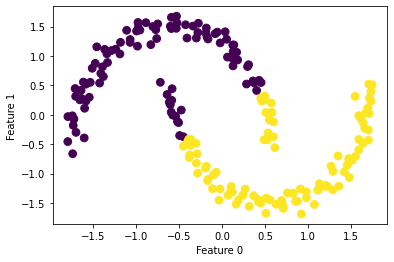

In [30]:
km = KMeans(n_clusters=2)
clusters = km.fit_predict(X_scaled)
plt.scatter(X_scaled[:, 0], X_scaled[:, 1], c=clusters, s=60)
plt.xlabel("Feature 0")
plt.ylabel("Feature 1")

print(silhouette_score(X_scaled, clusters))
print(adjusted_rand_score(y, clusters))

0.4572323945292666
0.6065184066117172


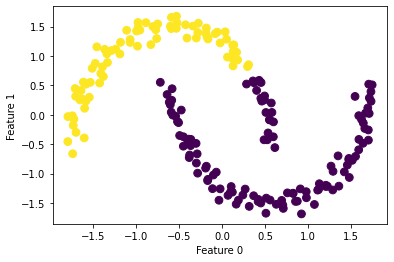

In [31]:
agg = AgglomerativeClustering(n_clusters=2)
clusters = agg.fit_predict(X_scaled)
plt.scatter(X_scaled[:, 0], X_scaled[:, 1], c=clusters, s=60)
plt.xlabel("Feature 0")
plt.ylabel("Feature 1")

print(silhouette_score(X_scaled, clusters))
print(adjusted_rand_score(y, clusters))

0.382386022679393
1.0


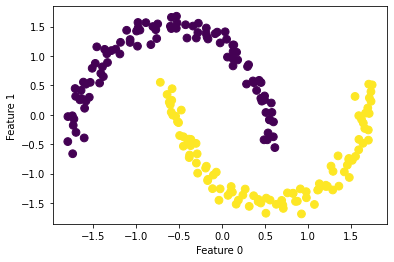

In [32]:
from sklearn.cluster import DBSCAN

dbscan = DBSCAN()
clusters = dbscan.fit_predict(X_scaled)
plt.scatter(X_scaled[:, 0], X_scaled[:, 1], c=clusters, s=60)
plt.xlabel("Feature 0")
plt.ylabel("Feature 1")

print(silhouette_score(X_scaled, clusters))
print(adjusted_rand_score(y, clusters))